In [2]:
import yt
filename = "/Users/bnowicki/Documents/Research/Ricotti/output_00273/info_00273.txt"

cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
    "Photon_density_2"
]


epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]

ds = yt.load(filename, fields=cell_fields, extra_particle_fields=epf)
ad = ds.all_data()
#star_ctr=galaxy_visualization.star_center(ad)
#sp = ds.sphere(star_ctr, (3000, "pc"))
#sp_lum = ds.sphere(star_ctr, (10, 'kpc'))
width = 1500


sim_run = filename.split('/')[-1]

print(ds.field_list)
display(ds.fields)

yt : [INFO     ] 2025-02-17 23:18:49,498 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2025-02-17 23:18:49,498 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-02-17 23:18:49,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-02-17 23:18:49,499 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-02-17 23:18:49,500 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-02-17 23:18:49,500 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2025-02-17 23:18:49,500 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2025-02-17 23:18:49,501 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2025-02-17 23:18:49,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-02-17 23:18:49,501 Parameters: hubble_constant           = 0.674000015258789
yt : [WARNING  ] 2025-02-17 23:18:53,731 This output has no 

[('gravity', 'Potential'), ('gravity', 'x-acceleration'), ('gravity', 'y-acceleration'), ('gravity', 'z-acceleration'), ('io', 'particle_birth_epoch'), ('io', 'particle_family'), ('io', 'particle_identity'), ('io', 'particle_mass'), ('io', 'particle_metallicity'), ('io', 'particle_position_x'), ('io', 'particle_position_y'), ('io', 'particle_position_z'), ('io', 'particle_refinement_level'), ('io', 'particle_tag'), ('io', 'particle_velocity_x'), ('io', 'particle_velocity_y'), ('io', 'particle_velocity_z'), ('nbody', 'particle_mass'), ('nbody', 'particle_position_x'), ('nbody', 'particle_position_y'), ('nbody', 'particle_position_z'), ('nbody', 'particle_velocity_x'), ('nbody', 'particle_velocity_y'), ('nbody', 'particle_velocity_z'), ('ramses', 'Density'), ('ramses', 'Metallicity'), ('ramses', 'Photon_density_2'), ('ramses', 'Pressure'), ('ramses', 'x-velocity'), ('ramses', 'xHI'), ('ramses', 'xHII'), ('ramses', 'xHeII'), ('ramses', 'xHeIII'), ('ramses', 'y-velocity'), ('ramses', 'z-ve

In [ ]:
max_

In [3]:
# importing packages
import numpy as np
import os
import emission
import yt
import copy
import sys
import galaxy_visualization

filename = "/Users/bnowicki/Documents/Research/Ricotti/output_00273"

# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

wavelengths=[6562.80, 1304.86, 6300.30, 3728.80, 3726.10, 1660.81, 1666.15, \
             4363.21, 4958.91, 5006.84, 1640.41, 1335.66, \
             1906.68, 1908.73, 1549.00, 2795.53, 2802.71, 3868.76, \
             3967.47, 1238.82, 1242.80, 1486.50, 1749.67, 6716.44, 6730.82]


cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]


epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]

          
# Ionization Parameter Field
# Based on photon densities in bins 2-4
# Don't include bin 1 -> Lyman Werner non-ionizing
def _ion_param(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c = 2.99792458e10     #light velocity
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']  

'''
def _my_temperature(field, data):
    #y(i): abundance per hydrogen atom
    XH_RAMSES=0.76 #defined by RAMSES in cooling_module.f90
    YHE_RAMSES=0.24 #defined by RAMSES in cooling_module.f90
    mH_RAMSES=yt.YTArray(1.6600000e-24,"g") #defined by RAMSES in cooling_module.f90
    kB_RAMSES=yt.YTArray(1.3806200e-16,"erg/K") #defined by RAMSES in cooling_module.f90

    dn=data["ramses","Density"].in_cgs()
    pr=data["ramses","Pressure"].in_cgs()
    yHI=data["ramses","xHI"]
    yHII=data["ramses","xHII"]
    yHe = YHE_RAMSES*0.25/XH_RAMSES
    yHeII=data["ramses","xHeII"]*yHe
    yHeIII=data["ramses","xHeIII"]*yHe
    yH2=1.-yHI-yHII
    yel=yHII+yHeII+2*yHeIII
    mu=(yHI+yHII+2.*yH2 + 4.*yHe) / (yHI+yHII+yH2 + yHe + yel)
    return pr/dn * mu * mH_RAMSES / kB_RAMSES
'''

#yt.add_field(("gas","my_temperature"),function=_my_temperature, units="K",sampling_type="cell")


# Luminosity field
# Cloudy Intensity obtained assuming height = 1cm
# Return intensity values erg/s/cm**2
# Multiply intensity at each pixel by volume of pixel -> luminosity
def get_luminosity(line):
   def _luminosity(field, data):
      return data['gas', 'intensity_' + line]*data['gas', 'volume']
   return copy.deepcopy(_luminosity)


yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", 
    force_override=True
)


# True divides emissions by density squared in interpolator
dens_normalized = True
if dens_normalized: 
    units = '1/cm**6'
else:
    units = '1'

# Add intensity and luminosity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        ('gas', 'intensity_' + lines[i]),
        function=emission.get_line_emission(i, dens_normalized),
        sampling_type='cell',
        units=units,
        force_override=True
    )
    
    yt.add_field(
        ('gas', 'luminosity_' + lines[i]),
        function=get_luminosity(lines[i]),
        sampling_type='cell',
        units='1/cm**3',
        force_override=True
    )

# Load Simulation Data
ds = yt.load(filename, extra_particle_fields=epf)
ad = ds.all_data()
#star_ctr=galaxy_visualization.star_center(ad)
#sp = ds.sphere(star_ctr, (3000, "pc"))
#sp_lum = ds.sphere(star_ctr, (10, 'kpc'))
width = 1500


sim_run = filename.split('/')[-1]

print(ds.field_list)

print(ds.field_info["ramses-rt", "Photon_density_1"].get_units())
print(ds.field_info["ramses-rt", "Photon_density_1"].get_source())

display(ds.fields)

-6.0 1.0 0.5 -1.0 6.0 0.5 3.0 6.0 0.1
(25, 6975)
15 15 31


yt : [INFO     ] 2025-02-17 23:19:20,944 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2025-02-17 23:19:20,944 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-02-17 23:19:20,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-02-17 23:19:20,945 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-02-17 23:19:20,946 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-02-17 23:19:20,946 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2025-02-17 23:19:20,947 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2025-02-17 23:19:20,947 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2025-02-17 23:19:20,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-02-17 23:19:20,948 Parameters: hubble_constant           = 0.674000015258789
yt : [INFO     ] 2025-02-17 23:19:20,953 Detected RAMSES-RT 

[('gravity', 'Potential'), ('gravity', 'x-acceleration'), ('gravity', 'y-acceleration'), ('gravity', 'z-acceleration'), ('io', 'particle_birth_epoch'), ('io', 'particle_family'), ('io', 'particle_identity'), ('io', 'particle_mass'), ('io', 'particle_metallicity'), ('io', 'particle_position_x'), ('io', 'particle_position_y'), ('io', 'particle_position_z'), ('io', 'particle_refinement_level'), ('io', 'particle_tag'), ('io', 'particle_velocity_x'), ('io', 'particle_velocity_y'), ('io', 'particle_velocity_z'), ('nbody', 'particle_mass'), ('nbody', 'particle_position_x'), ('nbody', 'particle_position_y'), ('nbody', 'particle_position_z'), ('nbody', 'particle_velocity_x'), ('nbody', 'particle_velocity_y'), ('nbody', 'particle_velocity_z'), ('ramses', 'Density'), ('ramses', 'HII'), ('ramses', 'HeII'), ('ramses', 'HeIII'), ('ramses', 'Metallicity'), ('ramses', 'Pres_IR'), ('ramses', 'Pressure'), ('ramses', 'var_10'), ('ramses', 'x-velocity'), ('ramses', 'y-velocity'), ('ramses', 'z-velocity'),

In [4]:
maxT = ad.max(('gas', 'temperature'))
print(maxT)

2451449966.2156982 K


yt : [INFO     ] 2025-02-13 09:43:09,823 Projection completed
yt : [INFO     ] 2025-02-13 09:43:09,824 xlim = 0.490913 0.491429
yt : [INFO     ] 2025-02-13 09:43:09,824 ylim = 0.492518 0.493034
yt : [INFO     ] 2025-02-13 09:43:09,826 xlim = 0.490913 0.491429
yt : [INFO     ] 2025-02-13 09:43:09,826 ylim = 0.492518 0.493034
yt : [INFO     ] 2025-02-13 09:43:09,829 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A')) 1000 by 1000



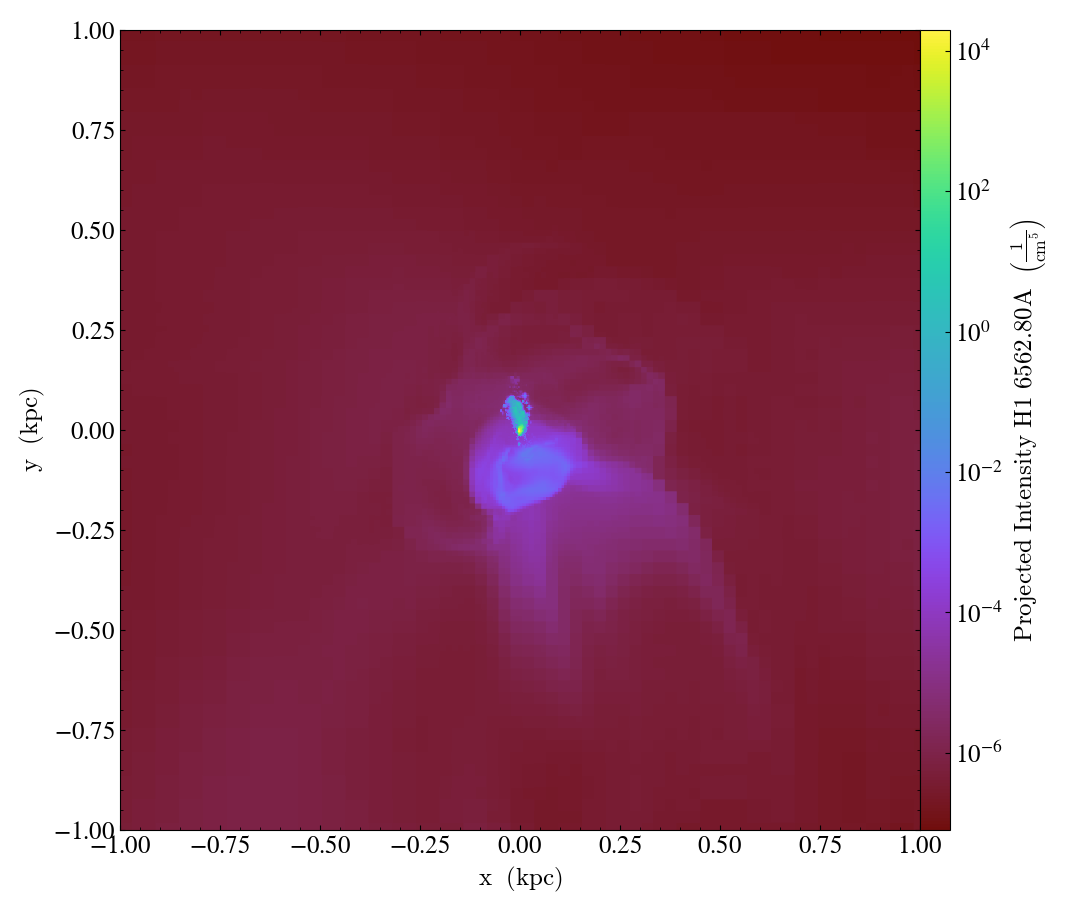

In [3]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_H1_6562.80A"), width=(2, 'kpc'),
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=star_ctr)

#p.save()
p.show()

yt : [INFO     ] 2025-02-13 11:53:05,938 Saving plot info_00273_2d-Profile_temperature_number_density_intensity_H1_6562.80A.png



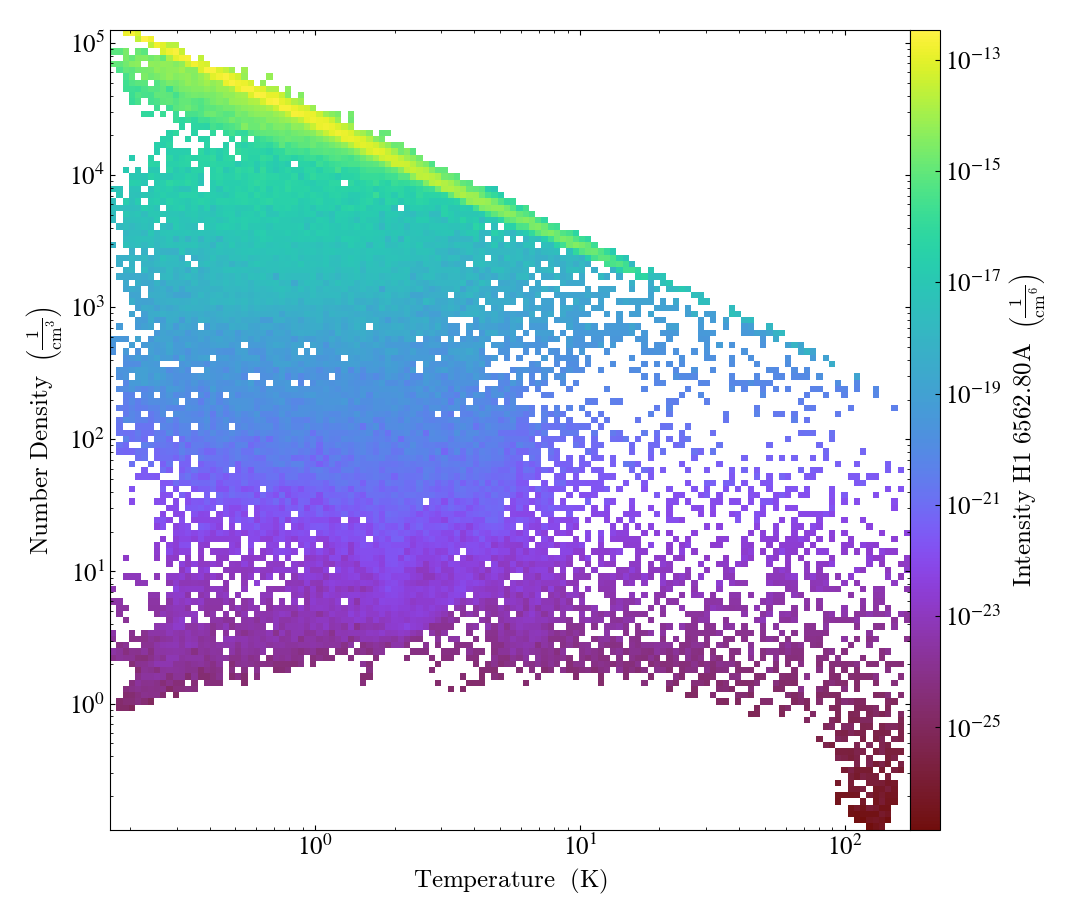

In [12]:
plot = yt.PhasePlot(
    sp, ("gas", "temperature"), ("gas", "number_density"), [("gas", "intensity_" + lines[0])], weight_field=None
)
plot.save()
plot.show()

yt : [INFO     ] 2025-02-13 12:19:02,475 Saving plot info_00273_2d-Profile_temperature_number_density_intensity_O2_3726.10A.png



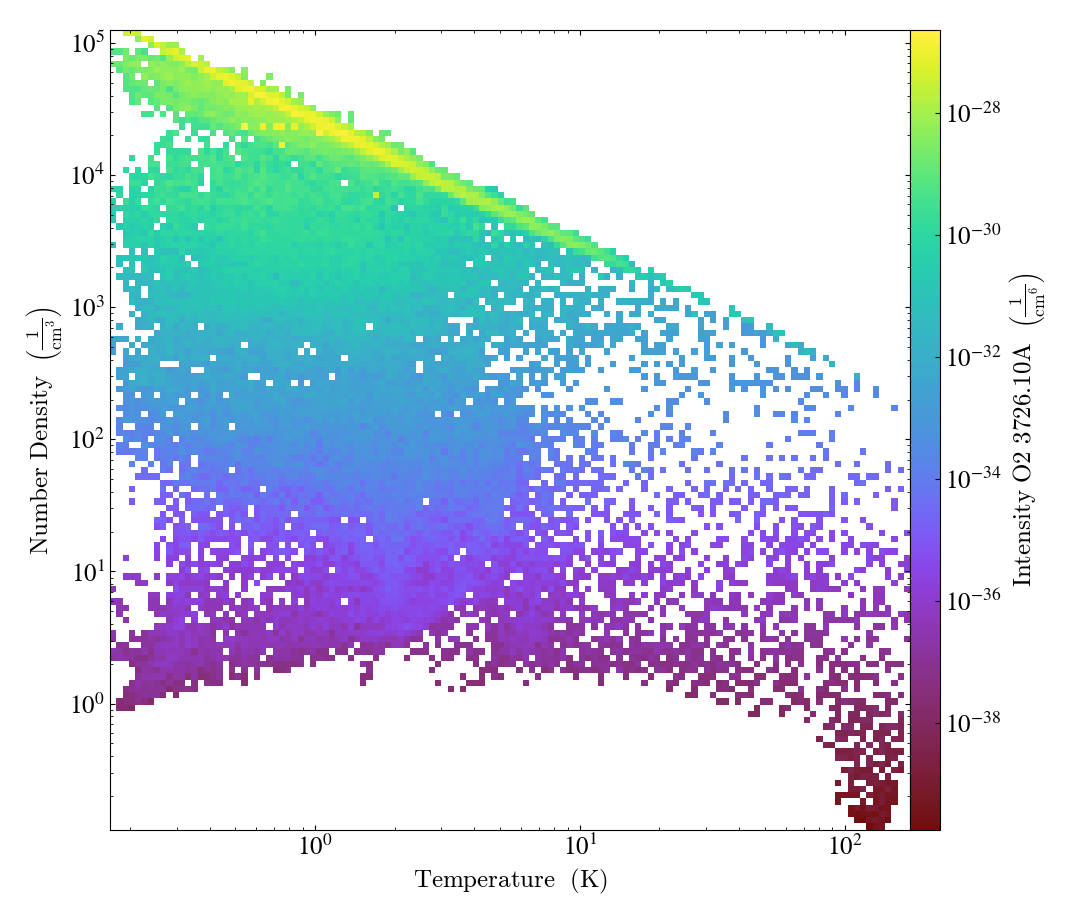

In [15]:
plot = yt.PhasePlot(
    sp, ("gas", "temperature"), ("gas", "number_density"), [("gas", "intensity_" + lines[4])], weight_field=None
)
plot.save()
plot.show()


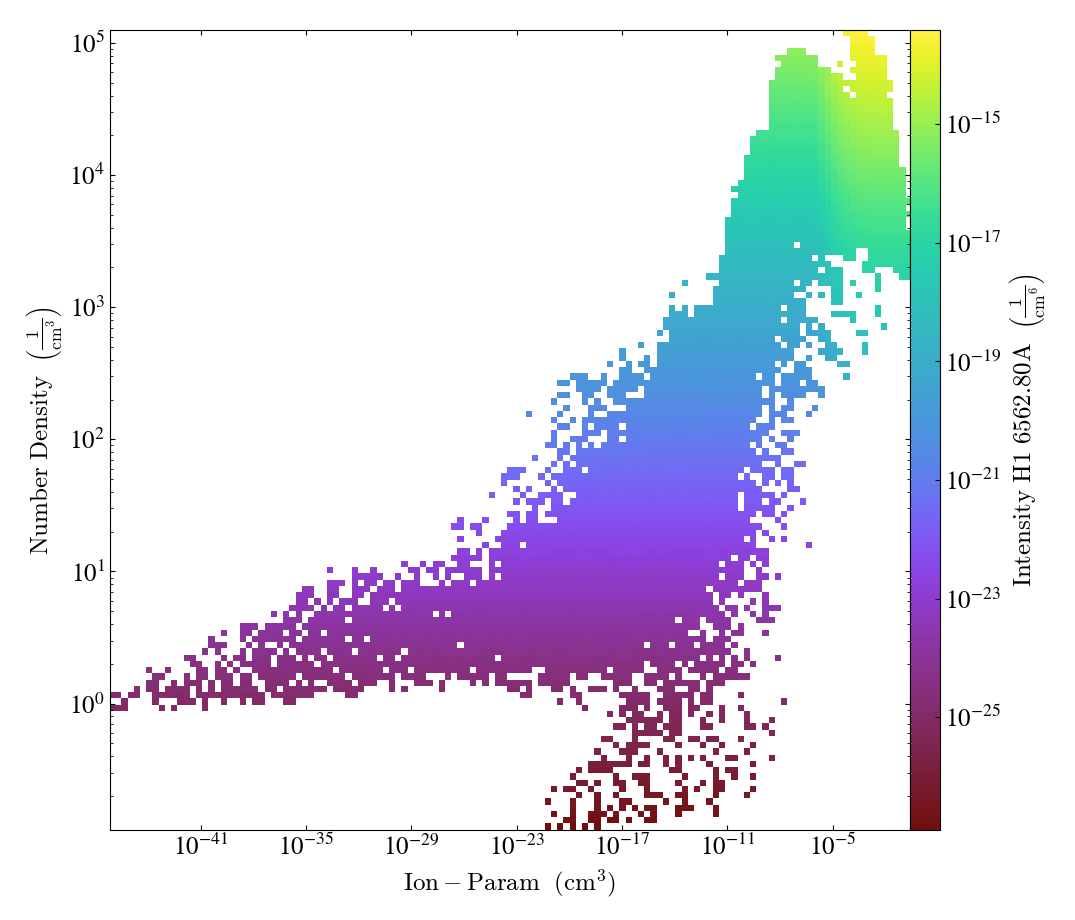

In [14]:
plot = yt.PhasePlot(
    sp, ("gas", "ion-param"), ("gas", "number_density"), [("gas", "intensity_" + lines[0])]
)
plot.save()
plot.show()

yt : [INFO     ] 2025-02-13 15:33:54,584 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-02-13 15:33:54,584 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-02-13 15:33:54,585 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-02-13 15:33:54,585 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-02-13 15:33:54,586 Making a fixed resolution buffer of (('gas', 'temperature')) 1000 by 1000



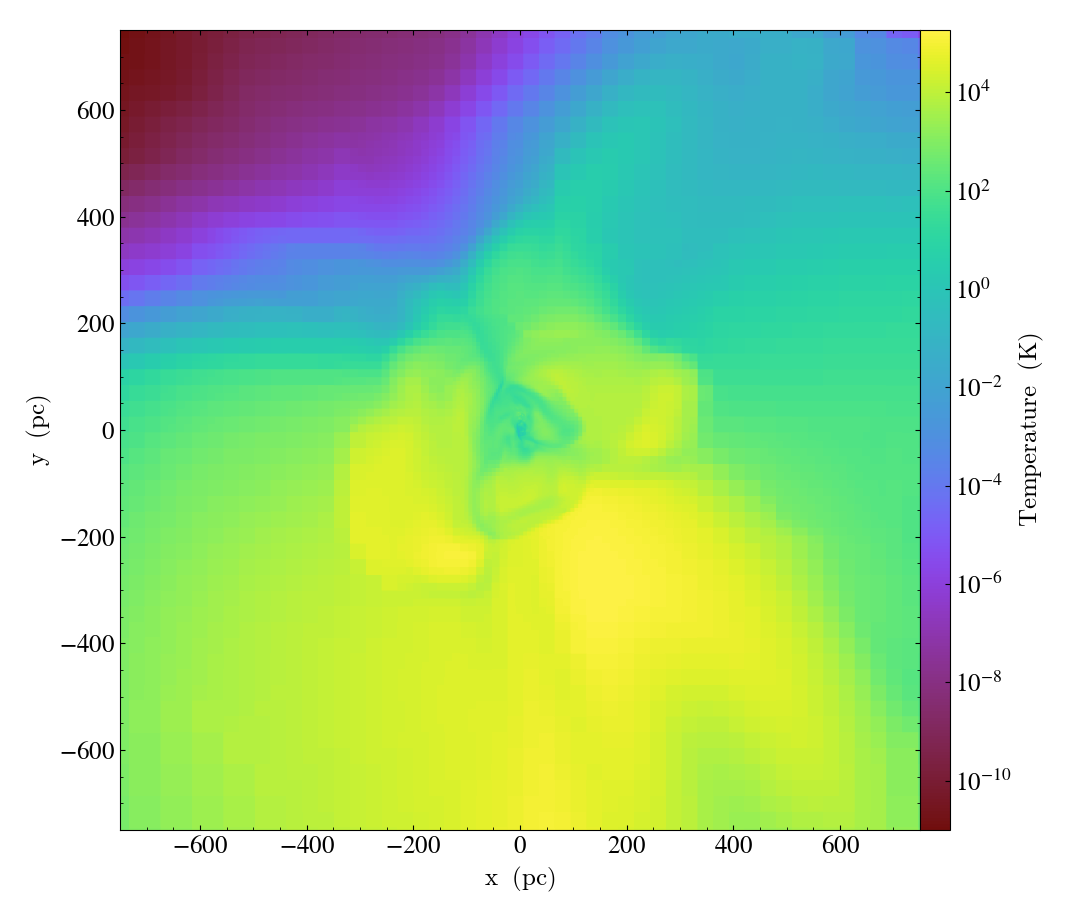

In [4]:
galaxy_visualization.slc_plot(ds, (1500, 'pc'), star_ctr, ("gas", "temperature"))

In [5]:
ds.fields